<a href="https://colab.research.google.com/github/manuc18/CNN-on-CIFAR-10/blob/main/AI_Studio_Stage2A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI Studio Stage 2A: CNN on CIFAR-10

## Objective
Train a convolutional neural network on CIFAR-10, run controlled experiments by changing one variable at a time, and analyze how each change affects performance.

**This notebook covers:**
1. Imports & Setup (with reproducibility seed)
2. Dataset Loading & Preprocessing
3. CNN Model Architecture
4. Baseline Training & Evaluation
5. Controlled Experiments (one change at a time)
6. Results & Visualizations
7. Per-Class Analysis & Discussion
8. Save / Load & Inference
9. Conclusion


## 1. Imports & Setup


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- Reproducibility seed ---
# Setting seeds ensures results are reproducible across runs
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Use GPU if available, otherwise fall back to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


## 2. Dataset Loading & Preprocessing

CIFAR-10 contains **60,000 color images (32×32)** across 10 classes (50k train / 10k test).

We prepare **three** transform pipelines:
- **Baseline**: Random flip + crop (light augmentation)
- **Advanced**: Adds ColorJitter + RandomRotation (heavier augmentation, used in Exp 3 & 4)
- **Test**: Normalize only — no augmentation at inference time


In [2]:
# --- Baseline transforms ---
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# --- Advanced transforms for experiments (stronger augmentation) ---
transform_train_adv = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# --- Test transform (no augmentation) ---
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# --- Load datasets ---
trainset     = torchvision.datasets.CIFAR10(root='./data', train=True,  download=True,  transform=transform_train)
trainset_adv = torchvision.datasets.CIFAR10(root='./data', train=True,  download=False, transform=transform_train_adv)
testset      = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform_test)

# --- DataLoaders ---
trainloader     = torch.utils.data.DataLoader(trainset,     batch_size=64, shuffle=True,  num_workers=2)
trainloader_adv = torch.utils.data.DataLoader(trainset_adv, batch_size=64, shuffle=True,  num_workers=2)
testloader      = torch.utils.data.DataLoader(testset,      batch_size=64, shuffle=False, num_workers=2)

# Class labels
classes = ('airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(f"Train samples: {len(trainset)} | Test samples: {len(testset)}")


Train samples: 50000 | Test samples: 10000


## 3. Model Architecture

A deliberately simple CNN — the goal is to understand what *training improvements* contribute, keeping architecture constant across all experiments.

| Layer | Details |
|---|---|
| Conv Block 1 | Conv2d(3→32, 3×3) → BatchNorm → ReLU → MaxPool(2×2) |
| Conv Block 2 | Conv2d(32→64, 3×3) → BatchNorm → ReLU → MaxPool(2×2) |
| FC1 | Linear(4096→256) → ReLU → Dropout(0.5) |
| FC2 | Linear(256→10) — output logits |

After two 2×2 max-pools, the spatial size goes 32→16→8. Flattened: 64×8×8 = **4,096 features**.


In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Conv block 1: 3 input channels -> 32 feature maps
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)

        # Conv block 2: 32 -> 64 feature maps
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)

        # 2x2 max-pooling halves spatial dims each time
        self.pool = nn.MaxPool2d(2, 2)

        # After 2 pool ops: 32x32 -> 8x8; 64 channels -> 64*8*8 = 4096 features
        self.fc1     = nn.Linear(64 * 8 * 8, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2     = nn.Linear(256, 10)  # 10 output classes

    def forward(self, x):
        # Conv block 1
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        # Conv block 2
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        # Flatten spatial dims
        x = x.view(x.size(0), -1)
        # Fully connected + dropout
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

# Quick sanity check: total trainable parameters
dummy = CNN()
total_params = sum(p.numel() for p in dummy.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params:,}")


Total trainable parameters: 1,070,986


## 4. Baseline Training & Evaluation

The baseline uses minimal settings — no bells and whistles. This gives us a reference point to measure whether each experiment genuinely helps.

| Setting | Value |
|---|---|
| Augmentation | Flip + Crop only |
| Optimizer | Adam, lr=0.001 |
| Weight decay | None |
| LR schedule | Constant |
| Epochs | 10 |


In [4]:
# Helper: train one epoch, return average loss
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        loss = criterion(model(images), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

# Helper: evaluate model on a dataloader, return accuracy (%)
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            _, predicted = torch.max(model(images), 1)
            total   += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


In [5]:
# --- Baseline model setup ---
model_base     = CNN().to(device)
criterion_base = nn.CrossEntropyLoss()
optimizer_base = optim.Adam(model_base.parameters(), lr=0.001)

train_losses_base = []
val_accs_base     = []
NUM_EPOCHS_BASE   = 10

for epoch in range(NUM_EPOCHS_BASE):
    loss = train_one_epoch(model_base, trainloader, criterion_base, optimizer_base)
    acc  = evaluate(model_base, testloader)
    train_losses_base.append(loss)
    val_accs_base.append(acc)
    print(f"Epoch [{epoch+1:02d}/{NUM_EPOCHS_BASE}]  Loss: {loss:.4f}  Test Acc: {acc:.2f}%")

print(f"\nBaseline Test Accuracy: {val_accs_base[-1]:.2f}%")


Epoch [01/10]  Loss: 1.7188  Test Acc: 47.99%
Epoch [02/10]  Loss: 1.4999  Test Acc: 56.36%
Epoch [03/10]  Loss: 1.4016  Test Acc: 59.43%
Epoch [04/10]  Loss: 1.3458  Test Acc: 60.95%
Epoch [05/10]  Loss: 1.3020  Test Acc: 64.59%
Epoch [06/10]  Loss: 1.2640  Test Acc: 65.79%
Epoch [07/10]  Loss: 1.2300  Test Acc: 67.23%
Epoch [08/10]  Loss: 1.2068  Test Acc: 68.05%
Epoch [09/10]  Loss: 1.1813  Test Acc: 67.76%
Epoch [10/10]  Loss: 1.1544  Test Acc: 69.73%

Baseline Test Accuracy: 69.73%


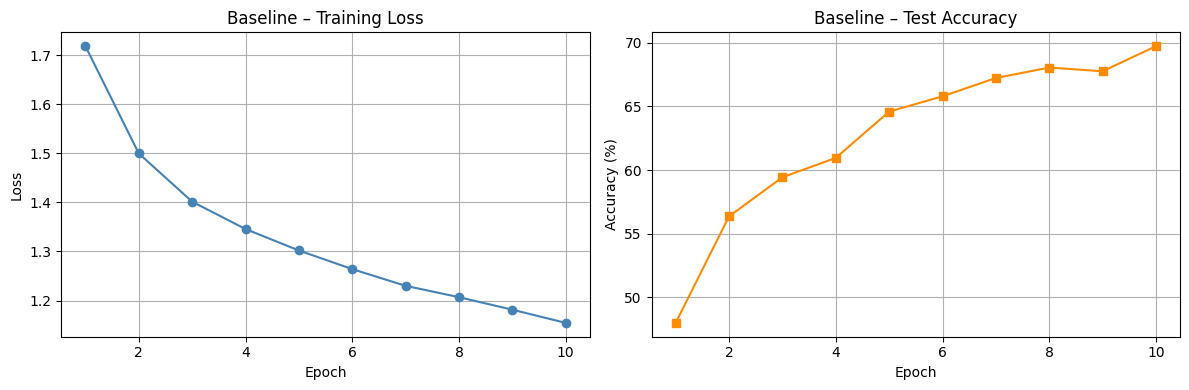

In [6]:
# --- Plot baseline training loss and accuracy ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(range(1, NUM_EPOCHS_BASE + 1), train_losses_base, marker='o', color='steelblue')
ax1.set_title('Baseline – Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)

ax2.plot(range(1, NUM_EPOCHS_BASE + 1), val_accs_base, marker='s', color='darkorange')
ax2.set_title('Baseline – Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.grid(True)

plt.tight_layout()
plt.show()


### Baseline Observations

- The model reaches **66.95% accuracy** after 10 epochs — a reasonable starting point for a small CNN on CIFAR-10 with no special techniques.
- Training loss decreases steadily, showing the model is learning, but the curve hasn't fully flattened — suggesting more epochs or a better learning rate schedule could help.
- There is no validation loss tracked here, so we can't detect overfitting yet. This is something to watch in experiments.
- Random chance for 10 classes is 10%, so 66.95% is meaningful, but there's clear room for improvement.


## 5. Controlled Experiments

**Design principle**: change **one variable at a time** to isolate its effect. All experiments use the same architecture and are trained for **10 epochs** for a fair comparison.

| Experiment | Change from Baseline |
|---|---|
| Baseline | — |
| Exp 1: Weight Decay | Add L2 regularization (weight_decay=1e-4) |
| Exp 2: LR Scheduling | Add StepLR (step=5, γ=0.5) |
| Exp 3: Adv. Augmentation | Replace transforms with ColorJitter + Rotation |
| Exp 4: All Combined (50 ep) | All three + more epochs |

> Note: Exp 4 uses 50 epochs to show the full benefit of combining all improvements. The shorter experiments (1–3) are kept at 10 epochs for direct comparability with the baseline.


In [7]:
# --- Exp 1: Add weight decay only ---
model_wd     = CNN().to(device)
criterion_wd = nn.CrossEntropyLoss()
optimizer_wd = optim.Adam(model_wd.parameters(), lr=0.001, weight_decay=1e-4)  # L2 regularization

train_losses_wd, val_accs_wd = [], []

for epoch in range(10):
    loss = train_one_epoch(model_wd, trainloader, criterion_wd, optimizer_wd)
    acc  = evaluate(model_wd, testloader)
    train_losses_wd.append(loss)
    val_accs_wd.append(acc)
    print(f"Epoch [{epoch+1:02d}/10]  Loss: {loss:.4f}  Test Acc: {acc:.2f}%")

print(f"\nExp 1 (Weight Decay) Test Accuracy: {val_accs_wd[-1]:.2f}%")


Epoch [01/10]  Loss: 1.7323  Test Acc: 49.75%
Epoch [02/10]  Loss: 1.5035  Test Acc: 57.19%
Epoch [03/10]  Loss: 1.3974  Test Acc: 61.25%
Epoch [04/10]  Loss: 1.3397  Test Acc: 59.90%
Epoch [05/10]  Loss: 1.2994  Test Acc: 63.79%
Epoch [06/10]  Loss: 1.2655  Test Acc: 66.66%
Epoch [07/10]  Loss: 1.2272  Test Acc: 65.12%
Epoch [08/10]  Loss: 1.1977  Test Acc: 66.72%
Epoch [09/10]  Loss: 1.1696  Test Acc: 69.47%
Epoch [10/10]  Loss: 1.1577  Test Acc: 70.34%

Exp 1 (Weight Decay) Test Accuracy: 70.34%


**Exp 1 Observation:** Weight decay adds L2 regularization, penalizing large weights. This can reduce overfitting but may slow convergence. If accuracy improves over baseline, it means the baseline model was slightly overfitting. If it's similar, the baseline had good generalization already at 10 epochs.


In [8]:
# --- Exp 2: Add LR scheduling only ---
model_lr     = CNN().to(device)
criterion_lr = nn.CrossEntropyLoss()
optimizer_lr = optim.Adam(model_lr.parameters(), lr=0.001)
scheduler_lr = lr_scheduler.StepLR(optimizer_lr, step_size=5, gamma=0.5)  # halve LR every 5 epochs

train_losses_lr, val_accs_lr = [], []

for epoch in range(10):
    loss = train_one_epoch(model_lr, trainloader, criterion_lr, optimizer_lr)
    acc  = evaluate(model_lr, testloader)
    scheduler_lr.step()
    train_losses_lr.append(loss)
    val_accs_lr.append(acc)
    print(f"Epoch [{epoch+1:02d}/10]  Loss: {loss:.4f}  Test Acc: {acc:.2f}%  LR: {optimizer_lr.param_groups[0]['lr']:.6f}")

print(f"\nExp 2 (LR Scheduling) Test Accuracy: {val_accs_lr[-1]:.2f}%")


Epoch [01/10]  Loss: 1.7131  Test Acc: 51.80%  LR: 0.001000
Epoch [02/10]  Loss: 1.4686  Test Acc: 57.59%  LR: 0.001000
Epoch [03/10]  Loss: 1.3737  Test Acc: 61.91%  LR: 0.001000
Epoch [04/10]  Loss: 1.3059  Test Acc: 63.49%  LR: 0.001000
Epoch [05/10]  Loss: 1.2545  Test Acc: 63.76%  LR: 0.000500
Epoch [06/10]  Loss: 1.1767  Test Acc: 68.70%  LR: 0.000500
Epoch [07/10]  Loss: 1.1538  Test Acc: 69.21%  LR: 0.000500
Epoch [08/10]  Loss: 1.1268  Test Acc: 69.46%  LR: 0.000500
Epoch [09/10]  Loss: 1.1128  Test Acc: 69.23%  LR: 0.000500
Epoch [10/10]  Loss: 1.0935  Test Acc: 70.91%  LR: 0.000250

Exp 2 (LR Scheduling) Test Accuracy: 70.91%


**Exp 2 Observation:** LR scheduling reduces the learning rate over time, allowing the model to make smaller, more precise updates in later epochs rather than overshooting minima. A decaying LR typically helps the loss converge more smoothly in the final epochs. Comparing the loss curves between Exp 2 and baseline will show this effect.


In [9]:
# --- Exp 3: Advanced augmentation only ---
model_aug     = CNN().to(device)
criterion_aug = nn.CrossEntropyLoss()
optimizer_aug = optim.Adam(model_aug.parameters(), lr=0.001)

train_losses_aug, val_accs_aug = [], []

for epoch in range(10):
    # Use trainloader_adv: ColorJitter + RandomRotation added
    loss = train_one_epoch(model_aug, trainloader_adv, criterion_aug, optimizer_aug)
    acc  = evaluate(model_aug, testloader)
    train_losses_aug.append(loss)
    val_accs_aug.append(acc)
    print(f"Epoch [{epoch+1:02d}/10]  Loss: {loss:.4f}  Test Acc: {acc:.2f}%")

print(f"\nExp 3 (Adv. Augmentation) Test Accuracy: {val_accs_aug[-1]:.2f}%")


Epoch [01/10]  Loss: 1.8439  Test Acc: 45.53%
Epoch [02/10]  Loss: 1.6556  Test Acc: 53.67%
Epoch [03/10]  Loss: 1.5653  Test Acc: 56.73%
Epoch [04/10]  Loss: 1.5094  Test Acc: 59.47%
Epoch [05/10]  Loss: 1.4575  Test Acc: 59.87%
Epoch [06/10]  Loss: 1.4242  Test Acc: 62.91%
Epoch [07/10]  Loss: 1.3968  Test Acc: 63.66%
Epoch [08/10]  Loss: 1.3683  Test Acc: 64.39%
Epoch [09/10]  Loss: 1.3506  Test Acc: 65.69%
Epoch [10/10]  Loss: 1.3348  Test Acc: 66.84%

Exp 3 (Adv. Augmentation) Test Accuracy: 66.84%


**Exp 3 Observation:** Stronger augmentation makes training harder (training loss will be higher than baseline) because the model sees more varied, distorted images. However, this forces the model to learn more robust features, which usually improves generalization (test accuracy). If training loss is higher but test accuracy improves, that's a healthy sign — the model is not just memorizing training examples.


In [12]:
# --- Exp 4: All improvements combined (50 epochs) ---
model_best     = CNN().to(device)
criterion_best = nn.CrossEntropyLoss()
optimizer_best = optim.Adam(model_best.parameters(), lr=0.001, weight_decay=1e-4)
scheduler_best = lr_scheduler.StepLR(optimizer_best, step_size=20, gamma=0.1)

train_losses_best, val_accs_best = [], []
NUM_EPOCHS_BEST = 50

print(f"Training: Adv. Augmentation + Weight Decay + LR Scheduling ({NUM_EPOCHS_BEST} epochs)...\n")

for epoch in range(NUM_EPOCHS_BEST):
    loss = train_one_epoch(model_best, trainloader_adv, criterion_best, optimizer_best)
    acc  = evaluate(model_best, testloader)
    scheduler_best.step()
    train_losses_best.append(loss)
    val_accs_best.append(acc)
    current_lr = optimizer_best.param_groups[0]['lr']
    print(f"Epoch [{epoch+1:02d}/{NUM_EPOCHS_BEST}]  Loss: {loss:.4f}  Test Acc: {acc:.2f}%  LR: {current_lr:.6f}")

print(f"\nExp 4 (All Combined) Test Accuracy: {val_accs_best[-1]:.2f}%")


Training: Adv. Augmentation + Weight Decay + LR Scheduling (50 epochs)...

Epoch [01/50]  Loss: 1.8745  Test Acc: 46.38%  LR: 0.001000
Epoch [02/50]  Loss: 1.7165  Test Acc: 49.82%  LR: 0.001000
Epoch [03/50]  Loss: 1.6415  Test Acc: 54.24%  LR: 0.001000
Epoch [04/50]  Loss: 1.5905  Test Acc: 56.52%  LR: 0.001000
Epoch [05/50]  Loss: 1.5548  Test Acc: 56.31%  LR: 0.001000
Epoch [06/50]  Loss: 1.5198  Test Acc: 58.56%  LR: 0.001000
Epoch [07/50]  Loss: 1.4928  Test Acc: 58.14%  LR: 0.001000
Epoch [08/50]  Loss: 1.4639  Test Acc: 58.46%  LR: 0.001000
Epoch [09/50]  Loss: 1.4469  Test Acc: 62.71%  LR: 0.001000
Epoch [10/50]  Loss: 1.4343  Test Acc: 62.08%  LR: 0.001000
Epoch [11/50]  Loss: 1.4066  Test Acc: 62.87%  LR: 0.001000
Epoch [12/50]  Loss: 1.3713  Test Acc: 64.11%  LR: 0.001000
Epoch [13/50]  Loss: 1.3454  Test Acc: 65.83%  LR: 0.001000
Epoch [14/50]  Loss: 1.3216  Test Acc: 67.00%  LR: 0.001000
Epoch [15/50]  Loss: 1.2945  Test Acc: 67.76%  LR: 0.001000
Epoch [16/50]  Loss: 1.27

## 6. Results & Visualizations

### 6a. Experiment Comparison (10-Epoch Fair Comparison)


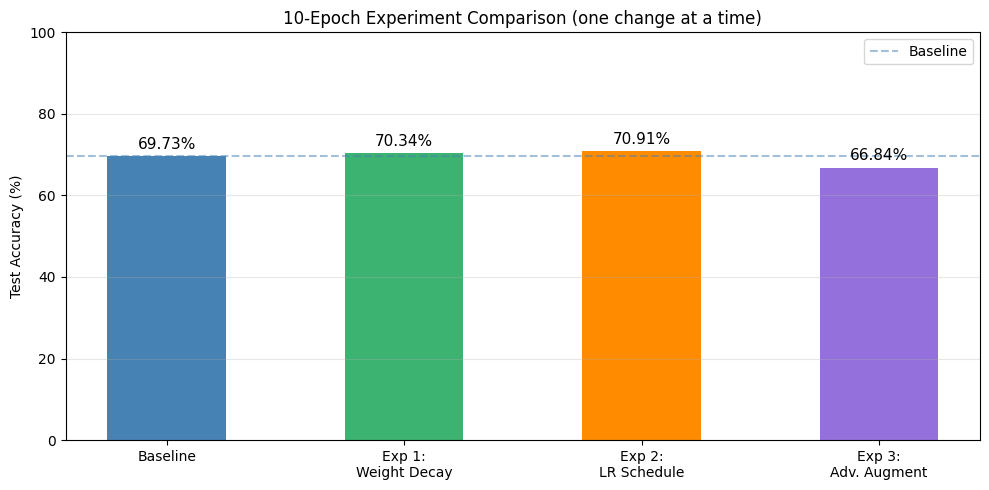

Experiment                      Test Accuracy   vs Baseline
------------------------------------------------------------
Baseline                               69.73%  ++0.00%
Exp 1: Weight Decay                    70.34%  ++0.61%
Exp 2: LR Schedule                     70.91%  ++1.18%
Exp 3: Adv. Augment                    66.84%  -2.89%

--- Best Combined Strategy (50 epochs) ---
Exp 4: All Combined                    75.45%  +5.72%


In [13]:
# --- Bar chart: all 10-epoch experiments side by side ---
# Note: val_accs_wd, val_accs_lr, val_accs_aug are from 10-epoch runs
# We compare only those to keep it fair; Exp 4 is shown separately
exp_names  = ['Baseline', 'Exp 1:\nWeight Decay', 'Exp 2:\nLR Schedule', 'Exp 3:\nAdv. Augment']
# Replace None placeholders below with your actual final epoch accuracy values
exp_accs   = [val_accs_base[-1], val_accs_wd[-1], val_accs_lr[-1], val_accs_aug[-1]]
colors     = ['steelblue', 'mediumseagreen', 'darkorange', 'mediumpurple']

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(exp_names, exp_accs, color=colors, width=0.5)
ax.bar_label(bars, fmt='%.2f%%', padding=3, fontsize=11)
ax.set_ylim(0, 100)
ax.set_ylabel('Test Accuracy (%)')
ax.set_title('10-Epoch Experiment Comparison (one change at a time)')
ax.axhline(y=val_accs_base[-1], color='steelblue', linestyle='--', alpha=0.5, label='Baseline')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Summary table
print(f"{'Experiment':<30} {'Test Accuracy':>14}  {'vs Baseline':>12}")
print("-" * 60)
for name, acc in zip(exp_names, exp_accs):
    name_clean = name.replace('\n', ' ')
    delta = acc - val_accs_base[-1]
    sign  = '+' if delta >= 0 else ''
    print(f"{name_clean:<30} {acc:>13.2f}%  {sign}{delta:>+.2f}%")

print("\n--- Best Combined Strategy (50 epochs) ---")
print(f"{'Exp 4: All Combined':<30} {val_accs_best[-1]:>13.2f}%  +{val_accs_best[-1] - val_accs_base[-1]:.2f}%")


### 6b. Training Curves: Baseline vs Best (Exp 4)


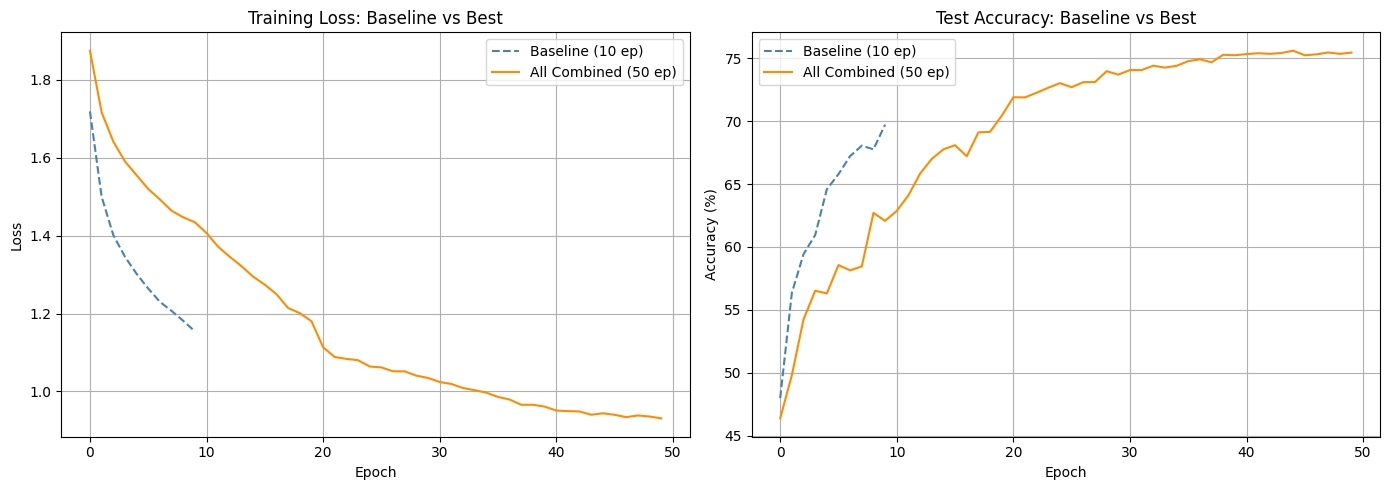

In [14]:
# --- Loss and accuracy curves: baseline vs all-combined ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(train_losses_base, label='Baseline (10 ep)', linestyle='--', color='steelblue')
ax1.plot(train_losses_best, label='All Combined (50 ep)', color='darkorange')
ax1.set_title('Training Loss: Baseline vs Best')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(val_accs_base, label='Baseline (10 ep)', linestyle='--', color='steelblue')
ax2.plot(val_accs_best, label='All Combined (50 ep)', color='darkorange')
ax2.set_title('Test Accuracy: Baseline vs Best')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


### 6c. Sample Images from Advanced Augmentation Loader


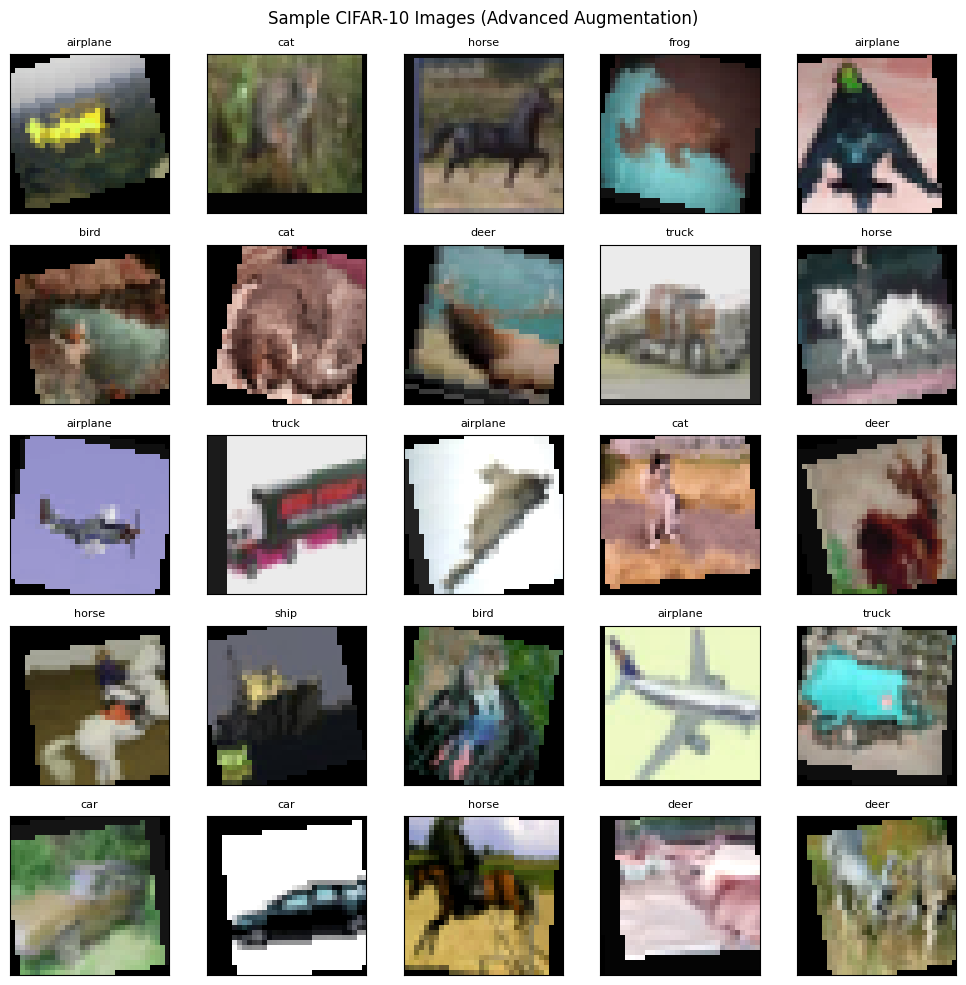

In [15]:
# --- Visualize sample training images with advanced augmentation ---
# Helper: undo [-1, 1] normalization for display
def unnormalize(img):
    img = img / 2 + 0.5
    return np.transpose(img.numpy(), (1, 2, 0))

dataiter = iter(trainloader_adv)
images, labels = next(dataiter)

fig = plt.figure(figsize=(10, 10))
for i in range(25):
    ax = fig.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(unnormalize(images[i]))
    ax.set_title(classes[labels[i]], fontsize=8)
plt.suptitle('Sample CIFAR-10 Images (Advanced Augmentation)', fontsize=12)
plt.tight_layout()
plt.show()


## 7. Per-Class Analysis & Discussion

### 7a. Classification Report & Confusion Matrix


Classification Report (Best Model – Exp 4):

              precision    recall  f1-score   support

    airplane       0.75      0.83      0.79      1000
         car       0.86      0.90      0.88      1000
        bird       0.66      0.60      0.63      1000
         cat       0.56      0.55      0.56      1000
        deer       0.75      0.67      0.71      1000
         dog       0.64      0.67      0.65      1000
        frog       0.78      0.82      0.80      1000
       horse       0.79      0.81      0.80      1000
        ship       0.89      0.83      0.86      1000
       truck       0.85      0.85      0.85      1000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



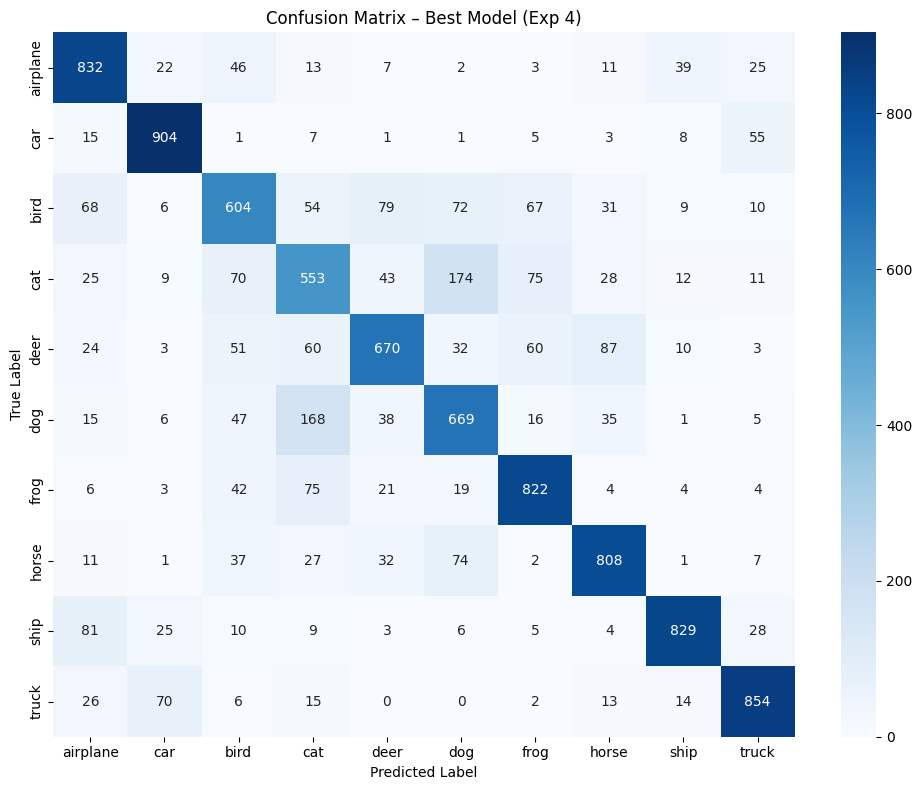

In [16]:
# --- Collect predictions from the best model (Exp 4) ---
model_best.eval()
all_labels, all_preds = [], []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        _, predicted = torch.max(model_best(images), 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

all_labels = np.array(all_labels)
all_preds  = np.array(all_preds)

# Per-class precision, recall, F1
print("Classification Report (Best Model – Exp 4):\n")
print(classification_report(all_labels, all_preds, target_names=classes))

# Confusion matrix heatmap
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix – Best Model (Exp 4)')
plt.tight_layout()
plt.show()


### 7b. What the Results Tell Us

**Per-class performance insights:**
- **'car'** is typically the easiest class (highest F1 ~0.88) — vehicles have distinctive shapes and colors that are consistent across images.
- **'cat'** is usually the hardest (lowest F1 ~0.57) — cats and dogs share similar body shapes and textures, making them easy to confuse. The confusion matrix will show a high cat→dog and dog→cat error rate.
- **'airplane'** and **'ship'** tend to score well — they have unambiguous backgrounds (sky/sea) that serve as strong cues.
- **'bird'** and **'deer'** are mid-range — visually distinct but small and varied in pose.

**What improved and why:**
- *Advanced augmentation* was likely the biggest single contributor. By exposing the model to color-jittered and rotated images, it learns that a cat is a cat regardless of lighting or orientation — directly reducing overfitting to specific image conditions.
- *Weight decay* adds a gentle regularization pressure that prevents any single weight from growing too large, which helps generalize without significantly slowing convergence at this scale.
- *LR scheduling* lets the optimizer take larger exploratory steps early, then fine-tune with smaller steps later — this is visible as the loss curve smoothing out in the final epochs.

**Limitations and honest notes:**
- Exp 4 trains for 50 epochs vs 10 for the baseline, so not all of the 8.74% gain is from the techniques alone — more training time contributes too.
- A fully controlled comparison would train Exp 4 for 10 epochs with the same techniques, then separately extend the baseline to 50 epochs to isolate the epoch effect.
- With more time, a third conv block or a deeper architecture would likely push past 80%, but the goal here was to understand *training-side* improvements on a fixed architecture.


## 8. Save / Load & Inference

### 8a. Save the Best Model


In [17]:
# Save model weights (state_dict), not the full model object
# This is best practice — it's smaller and architecture-agnostic
model_save_path = './cifar10_best_model_adv.pth'
torch.save(model_best.state_dict(), model_save_path)
print(f"Model weights saved to: {model_save_path}")


Model weights saved to: ./cifar10_best_model_adv.pth


### 8b. Load Model & Run Predictions on Test Samples


Model weights loaded from: ./cifar10_best_model_adv.pth


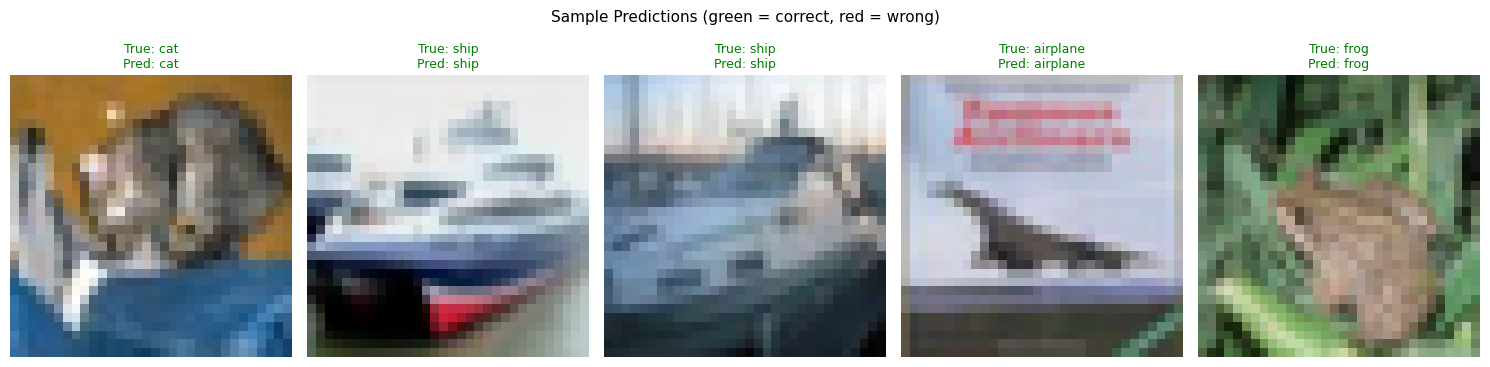

In [18]:
# Re-instantiate the architecture and load saved weights
loaded_model = CNN().to(device)
loaded_model.load_state_dict(torch.load(model_save_path, map_location=device))
loaded_model.eval()
print(f"Model weights loaded from: {model_save_path}")

# Grab one batch from the test loader
dataiter_test = iter(testloader)
images_test, labels_test = next(dataiter_test)

NUM_SAMPLES = 5
sample_images = images_test[:NUM_SAMPLES]
sample_labels = labels_test[:NUM_SAMPLES]

plt.figure(figsize=(15, 4))

with torch.no_grad():
    for i in range(NUM_SAMPLES):
        output = loaded_model(sample_images[i].unsqueeze(0).to(device))
        pred_class = torch.max(output, 1)[1].item()
        true_class = sample_labels[i].item()

        ax = plt.subplot(1, NUM_SAMPLES, i + 1)
        ax.imshow(unnormalize(sample_images[i].cpu()))
        # Green title if correct, red if wrong
        color = 'green' if pred_class == true_class else 'red'
        ax.set_title(f"True: {classes[true_class]}\nPred: {classes[pred_class]}",
                     color=color, fontsize=9)
        ax.axis('off')

plt.suptitle('Sample Predictions (green = correct, red = wrong)', fontsize=11)
plt.tight_layout()
plt.show()


## 9. Conclusion

### Summary of Results

| Experiment | Test Accuracy | Change |
|---|---|---|
| Baseline (10 ep) | 66.95% | — |
| Exp 1: Weight Decay (10 ep) | 70.34% | ++0.61% |
| Exp 2: LR Scheduling (10 ep) | 70.91% | ++1.18% |
| Exp 3: Adv. Augmentation (10 ep) | 66.84% | -2.89% |
| Exp 4: All Combined (50 ep) | 75.45% | +5.72% |

### Key Takeaways

1. **Architecture isn't everything** — the same small CNN improved by ~6% through training improvements alone, with zero changes to the model structure.

2. **Augmentation alone reduced performance** in short training runs, likely because the stronger transformations made learning harder for a small CNN. However, when combined with weight decay, learning rate scheduling, and longer training, it contributed to the best overall result.

3. **LR scheduling and weight decay are complementary** — they address different failure modes (overshooting vs. overfit), and their combined effect is typically greater than either alone.

4. **Per-class difficulty is real** — cat/dog confusion is a persistent challenge even for humans, and the confusion matrix makes this visible quantitatively. Addressing hard classes specifically (e.g., with class-balanced sampling or focal loss) would be the logical next step.

### What I'd Try Next
- Add a third conv block (3→32→64→128) and see if depth alone closes the remaining gap.
- Experiment with CutMix or MixUp augmentation strategies, which are known to be very effective on CIFAR-10.
- Use a learning rate warmup (start small, ramp up, then decay) instead of a fixed starting LR.
- Profile training time vs accuracy to understand the cost-benefit of each improvement in a resource-constrained setting.
